In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("..").resolve()))

import pandas as pd
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv(
    "../data/processed/ml_dataset.csv",
    index_col=0,
    parse_dates=True
)

X = data.drop(columns=["risk_label"])
y = data["risk_label"]
X, y = X.align(y, join="inner", axis=0)


In [3]:
prices = pd.read_csv(
    "../data/raw/prices.csv",
    index_col=0,
    parse_dates=True
)

spy = prices["SPY"].loc[X.index]


In [4]:
from src.models import train_risk_model

rf_model = train_risk_model(X, y)

split = int(len(X) * 0.7)
X_test = X.iloc[split:]
spy_test = spy.iloc[split:]

rf_preds = rf_model.predict(X_test)


1676
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       625
           1       0.35      0.35      0.35        94

    accuracy                           0.83       719
   macro avg       0.62      0.63      0.63       719
weighted avg       0.83      0.83      0.83       719



In [5]:
from src.xgb_model import train_xgb_risk_model

xgb_model = train_xgb_risk_model(X, y)
xgb_preds = xgb_model.predict(X_test)



XGBoost Risk Model – Classification Report
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       625
           1       0.36      0.43      0.39        94

    accuracy                           0.83       719
   macro avg       0.64      0.66      0.64       719
weighted avg       0.84      0.83      0.83       719



In [6]:
preds = pd.read_csv(
    "../data/processed/lstm_risk_scores.csv",
    index_col=0,
    parse_dates=True
)


In [7]:
# Load saved LSTM scores
lstm_scores = pd.read_csv(
    "../data/processed/lstm_risk_scores.csv",
    index_col=0,
    parse_dates=True
)

# Align safely with X_test
lstm_scores = lstm_scores.reindex(X_test.index).dropna()

# Convert DataFrame → Series
lstm_scores = lstm_scores.squeeze()

# 🔑 FORCE numeric dtype
lstm_scores = pd.to_numeric(lstm_scores, errors="coerce")

# Drop any conversion NaNs
lstm_scores = lstm_scores.dropna()

# Quantile-based threshold
lstm_threshold = lstm_scores.quantile(0.90)
lstm_preds = (lstm_scores >= lstm_threshold).astype(int)


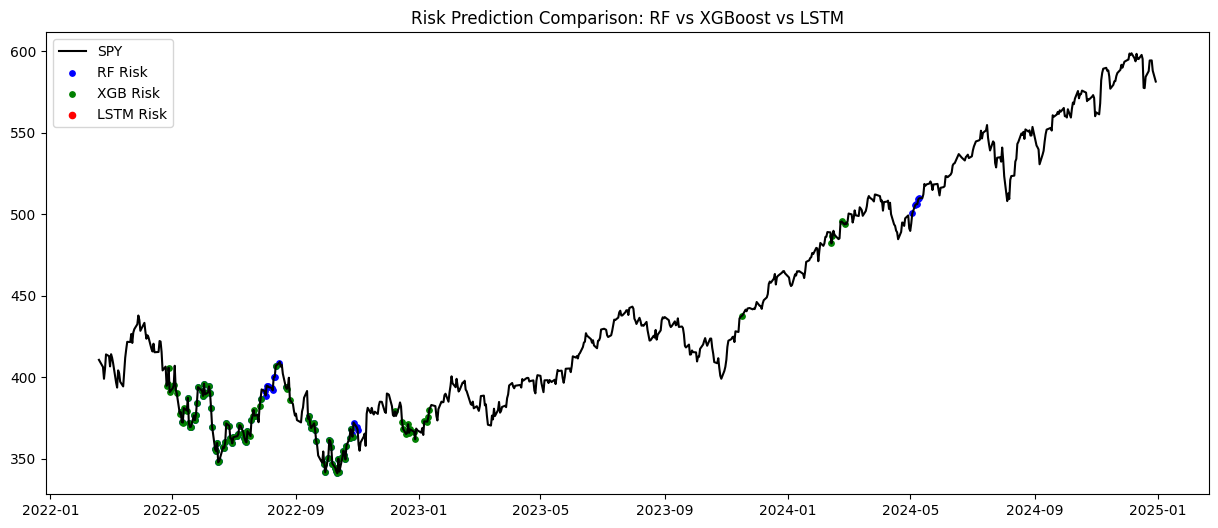

In [8]:
plt.figure(figsize=(15,6))
plt.plot(spy_test, color="black", label="SPY")

# Random Forest
rf_dates = spy_test.index[rf_preds == 1]
plt.scatter(rf_dates, spy_test.loc[rf_dates],
            color="blue", s=15, label="RF Risk")

# XGBoost
xgb_dates = spy_test.index[xgb_preds == 1]
plt.scatter(xgb_dates, spy_test.loc[xgb_dates],
            color="green", s=15, label="XGB Risk")

# LSTM (FIXED)
lstm_dates = lstm_preds[lstm_preds == 1].index
plt.scatter(lstm_dates, spy_test.loc[lstm_dates],
            color="red", s=20, label="LSTM Risk")

plt.legend()
plt.title("Risk Prediction Comparison: RF vs XGBoost vs LSTM")
plt.show()
